# Summary:

**NOTE:** Feature extraction is supposed to be run on your local-machine. Model training is supposed to be run also on local machine. Can be run on Google Colab.


**Another NOTE:** If you do not wish to extract the features yourself, go to the section "Load the dataset" and start from there after importing and correcting your paths.

Another Deep learning model for Gender Classification has been used. This model is the one and only Convolutional Neural Networks. Many researchers documented the potential for CNN's in Speech Recognition. The utilization of librosa's library in saving the spectrogram images of the audiofile and training the CNN on those spectograms is promising. The process goes as follows:
- Use librosa.display function to view the melspectrogram, the audio file must stay as it is without sampling to utilize all the possible features in the image.
- Export the images with no-axis and labels to a Folder that the notebook automatically creates in the main-directory.
- Generate train,test datasets by importing all the audio-files' names alongside the corresponding gender which is being used in the ImageDataGenerator by Keras.
- Shuffle, Shuffle, Shuffle.. Keep doing it :).
- Use the test-set to generate a validation-set, it is splitted in half (That is because my local machine couldn't generate the whole dataset, the memory kept getting overloaded and eventually crash, so I decided to take a subset of both training and test sets).
- Rescale the images (Normalize) to a factor of 1/2^(Sum of bits for each channel -RGB- 8 bits each).
- Perform Data Augmentation to increase the size of the dataset. The goal when performing data augmentation is to increase and improve the generalizability of the proposed model.
- Create a baseline model and an improved model with Hyperparameter tuning alongside a final model with Keras-tuner.
- Save the best nominated model.


**NOTE:** _The reason for having the **feature extraction** and the **model** together is because of the nature of ImageDataGenerator, I couldn't pickle the iterator as it was _thread.lock which means it is being used by the server-process. I decided to save every possible resource to avoid extracting the features again as it takes long time; for that, I ran the model on Google Colab and extracted the features with data-preprocessing on my local machine._

In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
audioread                    3.0.1
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.8.2
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
executing                    2.0.1


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install keras-tuner


   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 660.6 kB/s eta 0:00:01
   --------------------------- ----------- 92.2/129.1 kB 871.5 kB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.1 MB/s eta 0:00:00


In [1]:
import os
import librosa
import librosa.display
import random
import re
from datetime import datetime
import datetime
import time
import math
import shutil
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import seaborn as sns
sns.set();
import missingno

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Load Tensorboard
%load_ext tensorboard

**IMPORTANT:**
Specify the paths

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    print('Running on Colab, please run feature extraction on your local-machine, you can run the modeling on Google Colab.')
    dataPath_train = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-train/train-clean-100" # Path of train speakers folders.
    root_train = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-train" # Path of the Whole train dataset alongside the .txt files
    dataPath_test = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-test/test-clean" # Path of train speakers folders.
    root_test = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-test"  # Path of the Whole train dataset alongside the .txt files
    delimeter = '/' 
    delimeterM = '/' #A delimeter to distinguish between Local machine and Colab
    dest_save = '/content/drive/My Drive/Google Colab/Data/CNN-data' # Where to save the csv files.
    models_path = '/content/drive/My Drive/Google Colab/models'
    log_dir = '/content/drive/My Drive/Google Colab//log_dir/cnn' #For Tensorboard
else:
    print('Not Running on Google Colab')
    dataPath_train = "./Data/train-clean-100/LibriSpeech-train/train-clean-100" # Path of train speakers folders.
    root_train = "./Data/train-clean-100/LibriSpeech-train" # Path of the Whole train dataset alongside the .txt files
    dataPath_test = "./Data/test-clean/LibriSpeech-test/test-clean" # Path of train speakers folders.
    root_test = "./Data/test-clean/LibriSpeech-test"  # Path of the Whole train dataset alongside the .txt files
    delimeter = '/' 
    delimeterM = '\\' #A delimeter to distinguish between Local machine and Colab
    dest_save = './Data/CNN-data' # Where to save the csv files.
    models_path = './model'
    log_dir = './log_dir/cnn' #For Tensorboard

Not Running on Google Colab


**Create files for the images in the main-directory:**

In [5]:
# os.mkdir(dest_save + delimeter +'images-train')
# os.mkdir(dest_save + delimeter +'images-test')
# os.mkdir(dest_save + delimeter +'images-val')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './Data/CNN-data/images-train'

In [3]:
def extract_image(sound, sample_rate, name, destinationFolder, delimeter = '/'):
    """
    A function that saves the figure of the spectrogram to a destination folder.
    ...

    Parameters
    ----------
    sound : numpy.ndarray
        Signal wave-form extracted from librosa.
    sample_rate : numpy.ndarray
        Sampling rate for the generated signal from librosa.
    name : str
        Name of the audio file.
    destinationFolder : str
        Path to the images destination Folder.
        
    """
    #To remove axis and lables to keep the image as it without any additional framing.
    fig = plt.figure(figsize=[1,1])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    # The melspectrogram it can be considered as the visual representation of a signal.
    # In addition, it represents how the spectrum of frequencies vary over time.
    # This helps a lot, especially when the specification of the minimum frequency and the maximum frequency is present!
    spectrogram = librosa.feature.melspectrogram(y=sound, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), fmin=50, fmax=280, x_axis='time', y_axis='mel')
    
    file_name  = destinationFolder + delimeter + name + '.jpg'
    plt.savefig(file_name, dpi=500, pad_inches=0, bbox_inches='tight')
    
    plt.close()

In [4]:
def dataset_creation(dataPath, root, dest_save, dest_images, fileFormat=".flac", size = 5000 , audioPerFolder = 40, delimeter = '/', delimeterM = '\\'):
    """
    A function that crawls in the given file path to a specifize size of audio files then save a .jpg image of the spectrogram of 
    this audio-file to be used in the CNN model. In addition, return a dataset containing the names of audio-files alongside the corresponding gender.

    ...

    Parameters
    ----------
    dataPath : str
        The path where the dataset belongs.
    root : str
        The path of the dataset alongside the .txt files.
    dest_save : str
        Destination folder of the generated images (spectrograms).
    fileFormat : str
        Audio file format.
    size : int
        Maximum number of Audio-files in the dataset.
    audioPerFolder : int
        Audio file per speaker of a book to be generated.
    delimeter : str
        To be used for splitting and concatenating paths.
    delimeterM : str
        A delimeter to distinguish between Local machine and Google Colab.
        
    Returns
    -------
    pandas.DataFrame
        The whole generated Dataset.
        
    """
    
    #Initial Dataframe for the final generated dataset.
    df = pd.DataFrame(columns=['id_speaker', 'file_name'])
    
    # loading the features using extract_features function.
    i = 0

    for path, subdirs, files in os.walk(dataPath):
        if i == size:
            break;
        j = 0
        for name in files:
            if i == size: #if the files are equal to the total specified size of the dataset, break.
                break;
            print(name)
            #Retreive the speaker_id from the path.
            speaker_id = path.split(delimeterM)[-2].split(delimeter)[0]
            if name.endswith(fileFormat):
                #Retreive the signal and the default sample_rate from librosa.
                path_file = os.path.join(path, name)
                sound, sample_rate = librosa.load(path_file, res_type='kaiser_fast', sr=None) #sr=None to take the signal as it is without sampling
                extract_image(sound, sample_rate, name , dest_images)
                #Add them to the dataframe.
                df.loc[i,'id_speaker'] = speaker_id
                df.loc[i,'file_name'] = name +'.jpg' #Changed the name to .jpg to be used in ImageDataGenerator.
                i+=1
                j+=1 
                if j == audioPerFolder: #Number of audio-files per folder
                    break;

    
    print("##########################################################")
    print('Finished creating dataset Features, Now adding labels.')

    # Parsing the labels from SPEAKERS.txt file.
    labels = pd.DataFrame(columns=['id_speaker', 'gender'])
    f = open(root + '/' + "SPEAKERS.TXT", "r", encoding="UTF8").readlines()

    i = 0
    for idx, line in enumerate(f):
        if idx > 11: # Get rid of the unneeded sentences in the beginning for the parsing.
            parsed = re.split('\s+',line)
            if parsed[4] == dataPath.split(delimeter)[-1]: # To ensure taking the right speakers from the right train/test set.
                labels.loc[i] = parsed[0], parsed[2] # Labels
                i += 1

    dataset = pd.merge(df, labels, on='id_speaker')  # Joining both dataframes.
    
    #dataset["gender"].replace({"M": 1, "F": 0}, inplace=True) #Replacing M to 1 and F to 0.
    
    dataset.to_csv(dest_save + delimeter + 'images-'+ dest_images.split('-')[-1] +'.csv',index = False) # The dataset can be found in current-directory.
                                                          # This is for future purposes in case I want to improve on this notebook
    print('Finished Adding Labels.')
    return dataset

In [7]:
print("Generating training-set...")
dataset_train = dataset_creation(dataPath_train, root_train, dest_save, dest_save + delimeter + 'images-train', size = 5000, audioPerFolder = 10, delimeterM = delimeterM)

Generating training-set...
103-1240-0000.flac
103-1240-0001.flac
103-1240-0002.flac
103-1240-0003.flac
103-1240-0004.flac
103-1240-0005.flac
103-1240-0006.flac
103-1240-0007.flac
103-1240-0008.flac
103-1240-0009.flac
103-1241-0000.flac
103-1241-0001.flac
103-1241-0002.flac
103-1241-0003.flac
103-1241-0004.flac
103-1241-0005.flac
103-1241-0006.flac
103-1241-0007.flac
103-1241-0008.flac
103-1241-0009.flac
1034-121119-0000.flac
1034-121119-0001.flac
1034-121119-0002.flac
1034-121119-0003.flac
1034-121119-0004.flac
1034-121119-0005.flac
1034-121119-0006.flac
1034-121119-0007.flac
1034-121119-0008.flac
1034-121119-0009.flac
1040-133433-0000.flac
1040-133433-0001.flac
1040-133433-0002.flac
1040-133433-0003.flac
1040-133433-0004.flac
1040-133433-0005.flac
1040-133433-0006.flac
1040-133433-0007.flac
1040-133433-0008.flac
1040-133433-0009.flac
1069-133699-0000.flac
1069-133699-0001.flac
1069-133699-0002.flac
1069-133699-0003.flac
1069-133699-0004.flac
1069-133699-0005.flac
1069-133699-0006.flac

In [5]:
dataset_train

NameError: name 'dataset_train' is not defined

In [6]:
dataset_train.shape

NameError: name 'dataset_train' is not defined

In [10]:
dataset_train.head()

,id_speaker,file_name,gender
0,103,103-1240-0000.flac.jpg,F
1,103,103-1240-0001.flac.jpg,F
2,103,103-1240-0002.flac.jpg,F
3,103,103-1240-0003.flac.jpg,F
4,103,103-1240-0004.flac.jpg,F


In [11]:
# Shuffle the data.
dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)

In [12]:
dataset_train.head()

,id_speaker,file_name,gender
0,5390,5390-30096-0003.flac.jpg,M
1,4340,4340-15220-0008.flac.jpg,F
2,625,625-132118-0001.flac.jpg,M
3,2836,2836-5355-0008.flac.jpg,F
4,6836,6836-76549-0006.flac.jpg,M


In [13]:
print("Generating Test-set... ")
dataset_test = dataset_creation(dataPath_test, root_test, dest_save, dest_save + delimeter + 'images-test', size = 3000, audioPerFolder = 30,  delimeterM = delimeterM)

Generating Test-set... 
1089-134686-0000.flac
1089-134686-0001.flac
1089-134686-0002.flac
1089-134686-0003.flac
1089-134686-0004.flac
1089-134686-0005.flac
1089-134686-0006.flac
1089-134686-0007.flac
1089-134686-0008.flac
1089-134686-0009.flac
1089-134686-0010.flac
1089-134686-0011.flac
1089-134686-0012.flac
1089-134686-0013.flac
1089-134686-0014.flac
1089-134686-0015.flac
1089-134686-0016.flac
1089-134686-0017.flac
1089-134686-0018.flac
1089-134686-0019.flac
1089-134686-0020.flac
1089-134686-0021.flac
1089-134686-0022.flac
1089-134686-0023.flac
1089-134686-0024.flac
1089-134686-0025.flac
1089-134686-0026.flac
1089-134686-0027.flac
1089-134686-0028.flac
1089-134686-0029.flac
1089-134691-0000.flac
1089-134691-0001.flac
1089-134691-0002.flac
1089-134691-0003.flac
1089-134691-0004.flac
1089-134691-0005.flac
1089-134691-0006.flac
1089-134691-0007.flac
1089-134691-0008.flac
1089-134691-0009.flac
1089-134691-0010.flac
1089-134691-0011.flac
1089-134691-0012.flac
1089-134691-0013.flac
1089-134

In [14]:
print(dataset_test.shape)

(2038, 3)


In [15]:
dataset_test.head()

,id_speaker,file_name,gender
0,1089,1089-134686-0000.flac.jpg,M
1,1089,1089-134686-0001.flac.jpg,M
2,1089,1089-134686-0002.flac.jpg,M
3,1089,1089-134686-0003.flac.jpg,M
4,1089,1089-134686-0004.flac.jpg,M


In [16]:
# Specifying the shape of validation set.
shape_of_val = int(dataset_test.shape[0]*1/2)
print(shape_of_val)

1019


In [17]:
#Shuffle the data
dataset_test = dataset_test.sample(frac=1).reset_index(drop=True)

In [18]:
dataset_test.head()

,id_speaker,file_name,gender
0,5105,5105-28240-0002.flac.jpg,M
1,672,672-122797-0022.flac.jpg,M
2,1580,1580-141084-0021.flac.jpg,F
3,3575,3575-170457-0018.flac.jpg,F
4,5639,5639-40744-0009.flac.jpg,M


**Split the data in half:**
- Look for the spectrogram of the audio.
- Move it to the validation folder.
- Add it to validation DataFrame.
- Drop it from test DataFrame.

In [19]:
i =0
dataset_val = pd.DataFrame(columns=dataset_test.columns)
for file in dataset_test['file_name']:
    path = dest_save + '/images-test/'+ file
    to_path = dest_save + '/images-val/'
    shutil.move(path, to_path)
    dataset_val.loc[i,'id_speaker'] = dataset_test.loc[i,'id_speaker']
    dataset_val.loc[i,'file_name'] = dataset_test.loc[i,'file_name']
    dataset_val.loc[i,'gender'] = dataset_test.loc[i,'gender']
    dataset_test.drop(i, axis=0, inplace=True)
    i+=1
    if i == shape_of_val:
        break;

**Now the data is ready for modeling**:
- Save the data as CSV (Also update the test-set as it has been updated)
- Use ImageDataGenerator to use it as an iterator to build the images in batches. ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.
- Run CNN model with Dropout and specifying the epoch steps and validation steps (# of Samples / batch_size)
- Save the models

**Update the test-set's csv file and create a csv for the validation set:**

In [6]:
dataset_test.to_csv(dest_save + delimeter + 'images-'+ (dest_save + delimeter + 'images-test').split('-')[-1] +'.csv',index = False)

NameError: name 'dataset_test' is not defined

In [21]:
dataset_val.to_csv(dest_save + delimeter + 'images-'+ (dest_save + delimeter + 'images-val').split('-')[-1] +'.csv',index = False)

# Load the Dataset

In [6]:
dataset_train = pd.read_csv(dest_save + delimeter + 'images-train.csv')

In [7]:
dataset_test = pd.read_csv(dest_save + delimeter + 'images-test.csv')

In [8]:
dataset_val = pd.read_csv(dest_save + delimeter + 'images-val.csv')

In [9]:
print(dataset_train.shape, dataset_test.shape, dataset_val.shape)

(5000, 3) (1019, 3) (1019, 3)


In [10]:
datagen=ImageDataGenerator(rescale=1./255.)

In [11]:
train_generator=datagen.flow_from_dataframe(
    dataframe=dataset_train,
    directory=dest_save + "/images-train/",
    x_col="file_name",
    y_col="gender",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 5000 validated image filenames belonging to 2 classes.


In [12]:
val_generator=datagen.flow_from_dataframe(
    dataframe=dataset_val,
    directory=dest_save + "/images-val/",
    x_col="file_name",
    y_col="gender",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 1019 validated image filenames belonging to 2 classes.


In [13]:
test_generator=datagen.flow_from_dataframe(
    dataframe=dataset_test,
    directory=dest_save + "/images-test/",
    x_col="file_name",
    y_col="gender",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 1019 validated image filenames belonging to 2 classes.


In [ ]:
# Membaca file CSV
file_name = 'images-test.csv'
df = pd.read_csv(file_name)
df.head()


In [17]:

# Membuat histogram untuk gender
plt.figure(figsize=(6, 4))
df['gender'].value_counts().plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Histogram of Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

NameError: name 'df' is not defined

<Figure size 600x400 with 0 Axes>

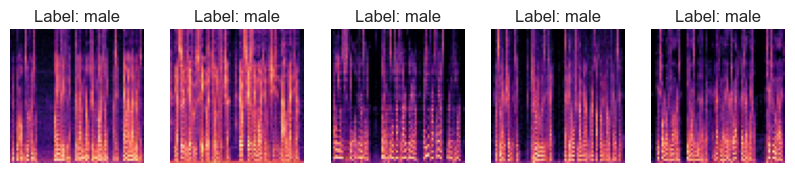

In [15]:
# Mengambil batch pertama dari train_generator
x_batch, y_batch = next(train_generator)

# Menampilkan 5 gambar pertama dari batch
plt.figure(figsize=(10, 10))
for i in range(5):
    # Plotting gambar
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_batch[i])
    
    # Mengubah label menjadi "female" dan "male"
    label = "female" if np.argmax(y_batch[i]) == 0 else "male"
    
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.show()

In [14]:
def plot_accuracy_loss(acc_train, acc_val, loss_train, loss_val):
    """
    A fuction that plots the Training & Validation accuracy alongside the plot for loss.
    ...

    Parameters
    ----------
    acc_train : list
        Training Accuracies.
    acc_val : list
        Validation Accuracies.
    loss_train : list
        Training Losses.
    loss_val : list
        Validation Losses.
        
    """

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30,15))

    ax1.plot(acc_train, label='Training Accuracy', color='#185fad')
    ax1.plot(acc_val, label='Validation Accuracy', color='orange')

    ax2.plot(loss_train, label='Training Loss', color='#185fad')
    ax2.plot(loss_val, label='Validation Loss', color='orange')


    ax1.set_title('Training and Validation Accuracy', fontsize=30)
    ax1.set_xlabel('Epoch', fontsize = 30)
    ax1.set_ylabel('Accuracy', fontsize = 30)
    ax1.legend(fontsize = 30);
    ax2.set_title('Training and Validation Loss', fontsize=30)
    ax2.set_xlabel('Epoch', fontsize = 30)
    ax2.set_ylabel('Accuracy', fontsize = 30)
    ax2.legend(fontsize = 30);
    plt.tight_layout()
    plt.show();

# Proposed CNN Models:
In this section, different models will be tested on, starting off with the Baseline Model as it will contain an intuitive architecture for a deep CNN; afterwards a comparison is present with loss and accuracy to observe where the model is going.
The following is present:
- Create a Baseline model and observe the results visually.
- Create an improved model where one-to-max two parameters are tuned.
- Create a keras-tuner with some parameters that are based on Grid Search on this CNN.
- Pick the best model to be nominated for the next step.


**Baseline Model:**


In [15]:
# Tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir+'/Baseline')

baseline_model = Sequential()

# 3X3X32 filters, RGB 64x64 input image.
baseline_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64,64,3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Flatten()) #Fully Connected Layer
baseline_model.add(Dense(512, activation='relu'))

baseline_model.add(Dense(128, activation='relu')) #Fully Connected Layer

baseline_model.add(Dense(2, activation='softmax'))

baseline_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])


In [16]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569,410 (2.17 MB)

 Trainable params: 569,410 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
baseline_history = baseline_model.fit(x=train_generator,
                                      steps_per_epoch=int(dataset_train.shape[0]/32),
                                      validation_data=val_generator, 
                                      validation_steps=int(dataset_val.shape[0]/32),
                                      epochs=25,
                                      callbacks=[tensorboard_callback])


Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 289ms/step - accuracy: 0.5215 - loss: 0.6916 - val_accuracy: 0.5383 - val_loss: 0.6895
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.6850 - val_accuracy: 0.4815 - val_loss: 0.6927
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5315 - loss: 0.6897 - val_accuracy: 0.5383 - val_loss: 0.6868
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 0.5312 - loss: 0.6881 - val_accuracy: 0.4815 - val_loss: 0.6925
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5285 - loss: 0.6888 - val_accuracy: 0.5534 - val_loss: 0.6868
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 165us/step - accuracy: 0.6250 - loss: 0.6862 - val_accuracy: 0.4815 - val_loss: 0.6889
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5752 - loss: 0.6858 - val_accuracy: 0.5383 - val_loss: 0.6812
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - accuracy: 0.5312 - loss: 0.6782 - val_

In [18]:
loss, acc = baseline_model.evaluate(test_generator, steps=len(test_generator))


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.9224 - loss: 0.2106


In [19]:
print("Loss:", loss, "Accuracy:", acc)

Loss: 0.21222330629825592 Accuracy: 0.915603518486023


_As per above; 94.86% for a Baseline model is quite great!
  The parameters are simple with no regularization._
  
  _Due to this good accuracy as a baseline model, adding dropout to the Improved model shall have a good effect and flatten the the loss curve a bit.._

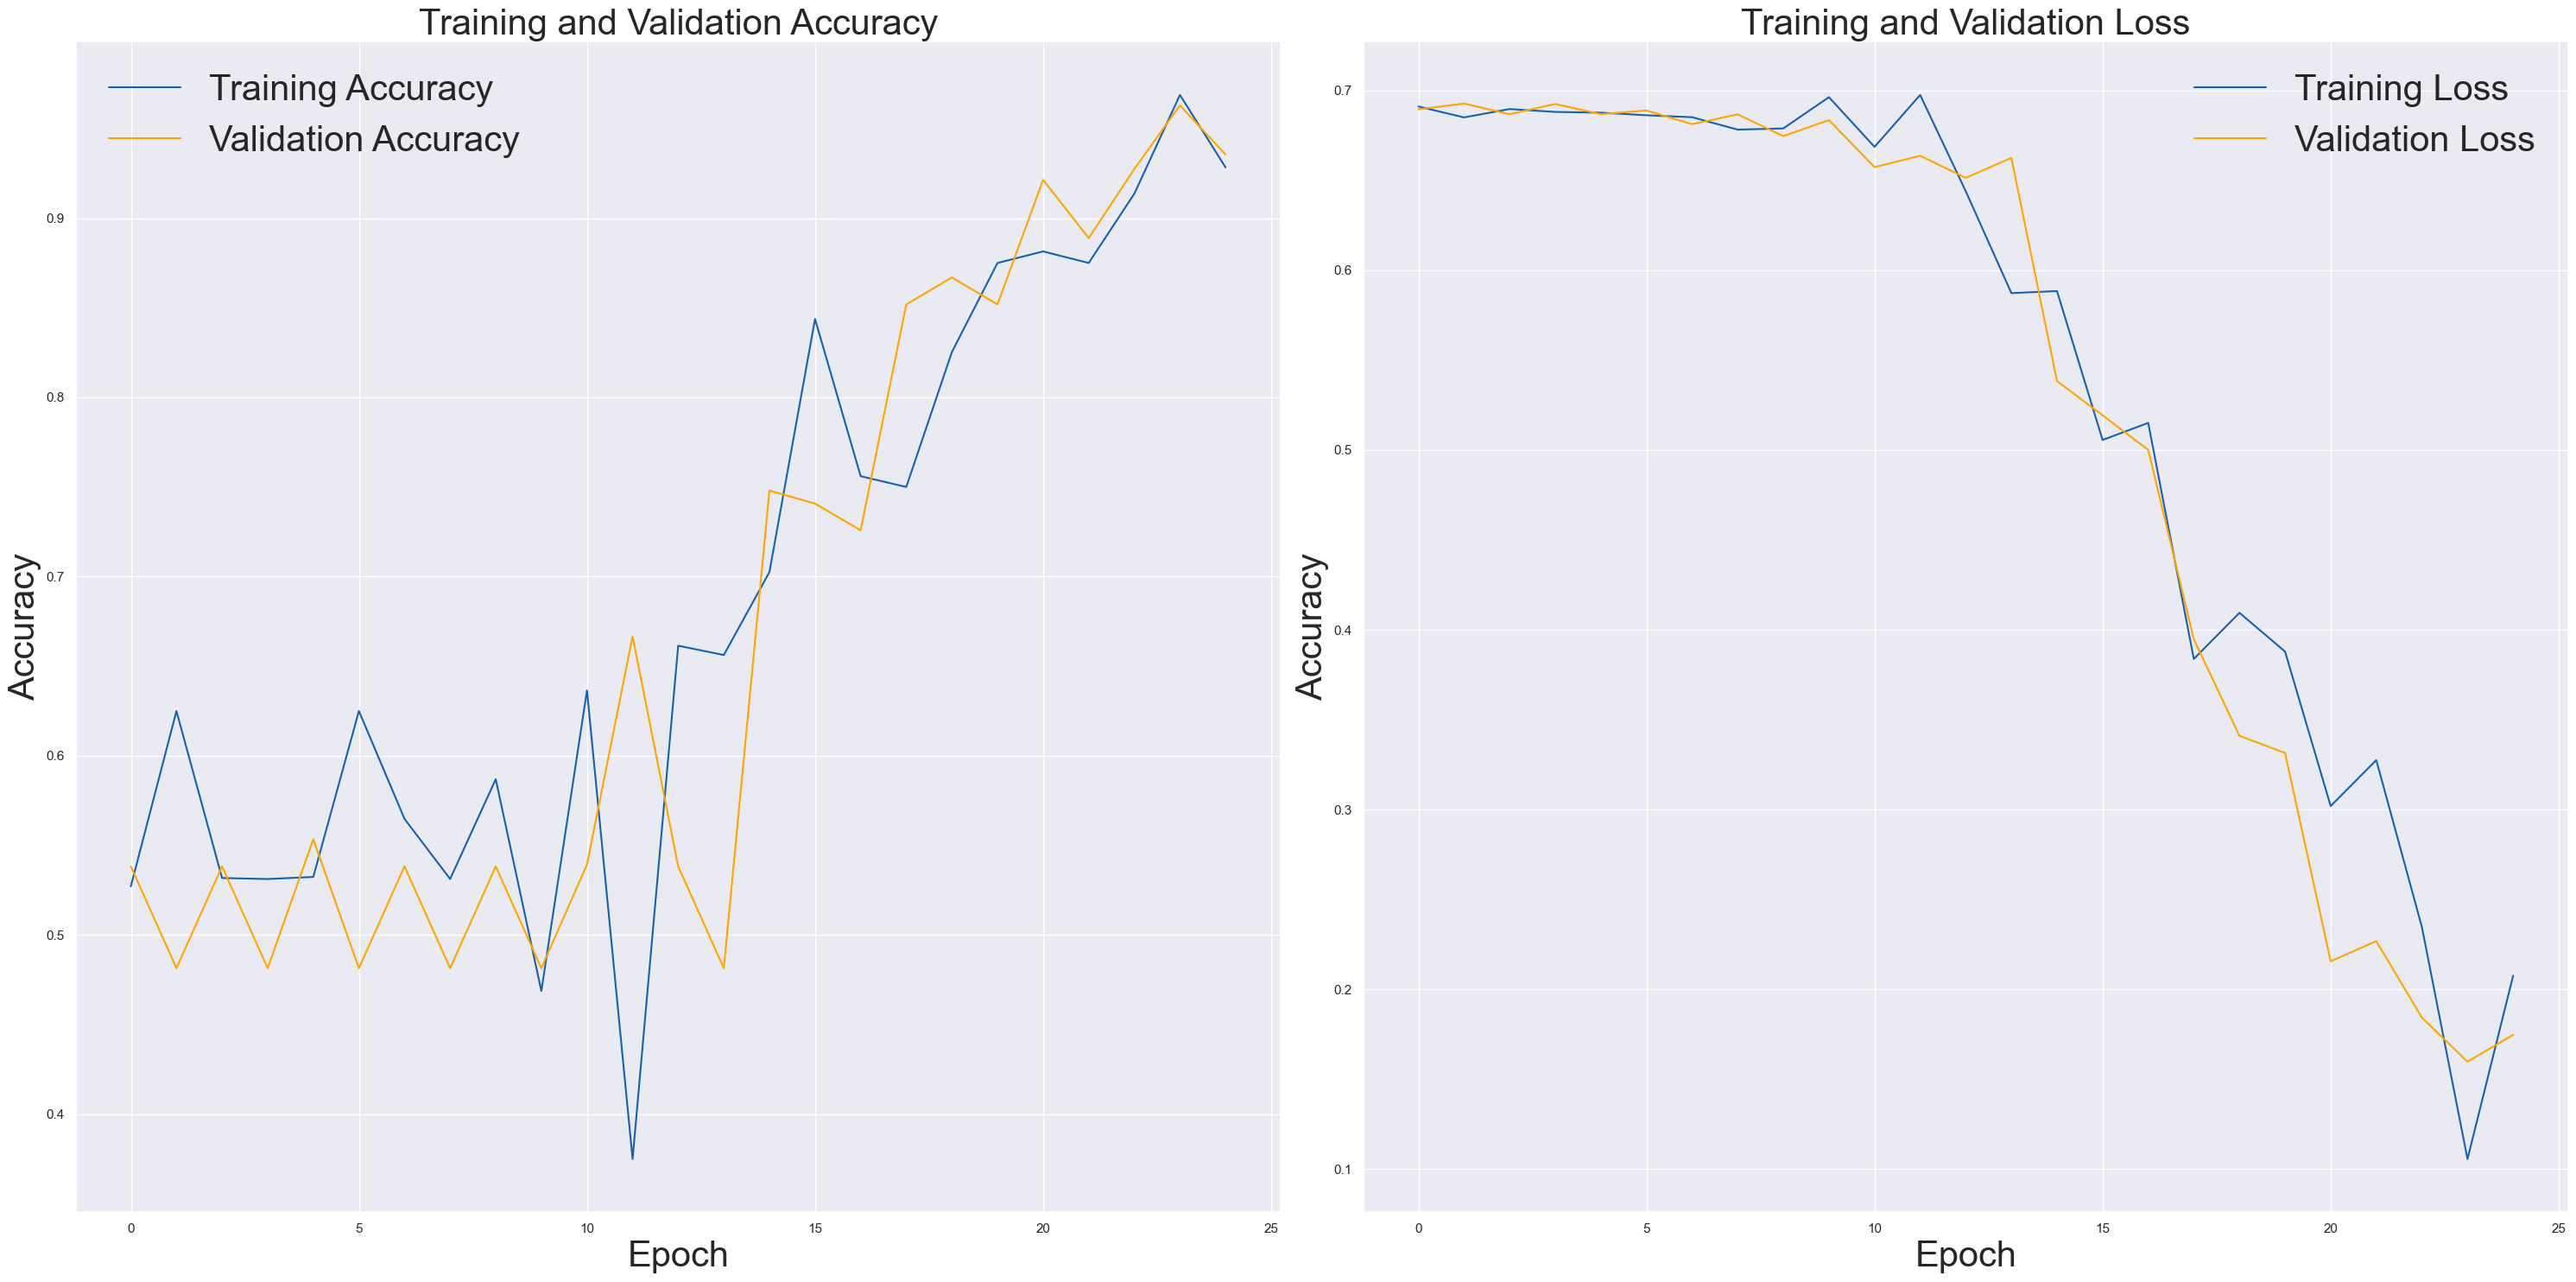

In [20]:
train_acc_baseline = baseline_history.history['accuracy']
val_acc_baseline = baseline_history.history['val_accuracy']
train_loss_baseline = baseline_history.history['loss']
val_loss_baseline = baseline_history.history['val_loss']


plot_accuracy_loss(train_acc_baseline, val_acc_baseline, train_loss_baseline, val_loss_baseline)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


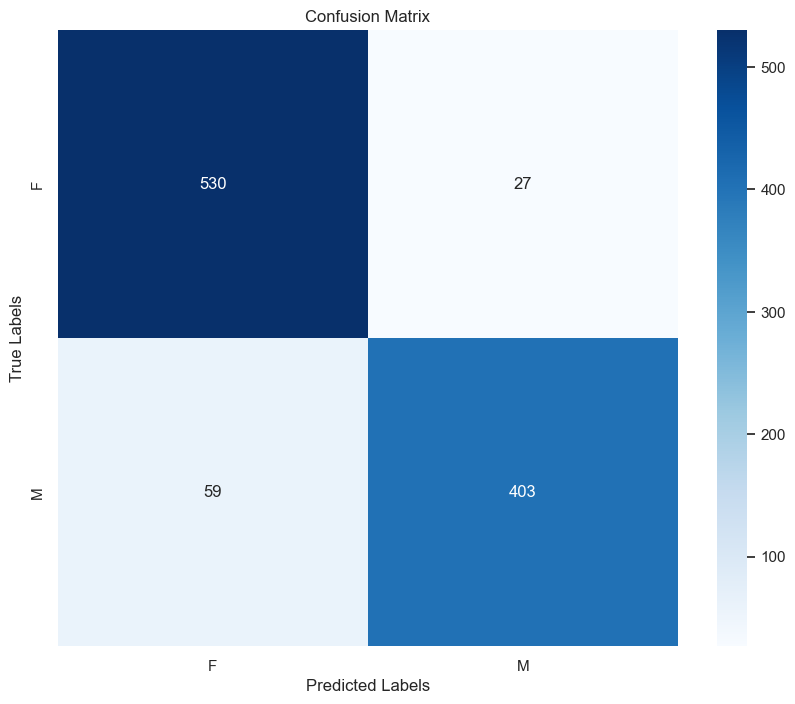

              precision    recall  f1-score   support

           F       0.90      0.95      0.92       557
           M       0.94      0.87      0.90       462

    accuracy                           0.92      1019
   macro avg       0.92      0.91      0.91      1019
weighted avg       0.92      0.92      0.92      1019



In [41]:
test_generator.reset()
predictions = baseline_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan label asli dari data uji
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Laporan klasifikasi
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

_Tensorboard (Optional)_

In [27]:
%tensorboard --logdir logdir + '/Baseline'

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-08-01 22:46:09.720658: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 22:46:10.396112: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]

**Improved model:**

In [16]:
# Tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir+'/BaselineImproved')

imp_model = Sequential()

# 3X3X32 filters, RGB 64x64 input image.
imp_model.add(Conv2D(kernel_size=(3, 3), filters = 32, input_shape=(64, 64, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))

imp_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))
imp_model.add(Dropout(0.3)) #Add dropout

imp_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))
imp_model.add(Dropout(0.4))
imp_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))
imp_model.add(Dropout(0.4))

imp_model.add(Flatten()) #Fully Connected Layer
imp_model.add(Dense(512, activation='relu'))
imp_model.add(Dropout(0.3))
imp_model.add(Dense(128, activation='relu')) #Fully Connected Layer
imp_model.add(Dropout(0.2))
imp_model.add(Dense(2, activation='softmax'))

imp_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.7),
                  metrics=['accuracy']) #Add momentum.


In [22]:
imp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569,410 (2.17 MB)

 Trainable params: 569,410 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
imp_history = imp_model.fit(x=train_generator,
                            steps_per_epoch=int(dataset_train.shape[0]/32),
                            validation_data=val_generator, 
                            validation_steps=int(dataset_val.shape[0]/32),
                            epochs=25,
                            callbacks=[tensorboard_callback])

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5065 - loss: 0.6995 - val_accuracy: 0.5383 - val_loss: 0.6900
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - accuracy: 0.5312 - loss: 0.7060 - val_accuracy: 0.4815 - val_loss: 0.6969
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5188 - loss: 0.6934 - val_accuracy: 0.5383 - val_loss: 0.6901
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.4688 - loss: 0.6983 - val_accuracy: 0.4815 - val_loss: 0.6957
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5181 - loss: 0.6917 - val_accuracy: 0.5383 - val_loss: 0.6895
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.5938 - loss: 0.6826 - val_accuracy: 0.4815 - val_loss: 0.6926
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5333 - loss: 0.6905 - val_accuracy: 0.5383 - val_loss: 0.6880
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.4688 - loss: 0.7014 - val_

In [24]:
loss, acc = imp_model.evaluate(test_generator, steps=len(test_generator))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9162 - loss: 0.2150


In [25]:
print("Loss:", loss, "Accuracy:", acc)

Loss: 0.2263655811548233 Accuracy: 0.9165849089622498


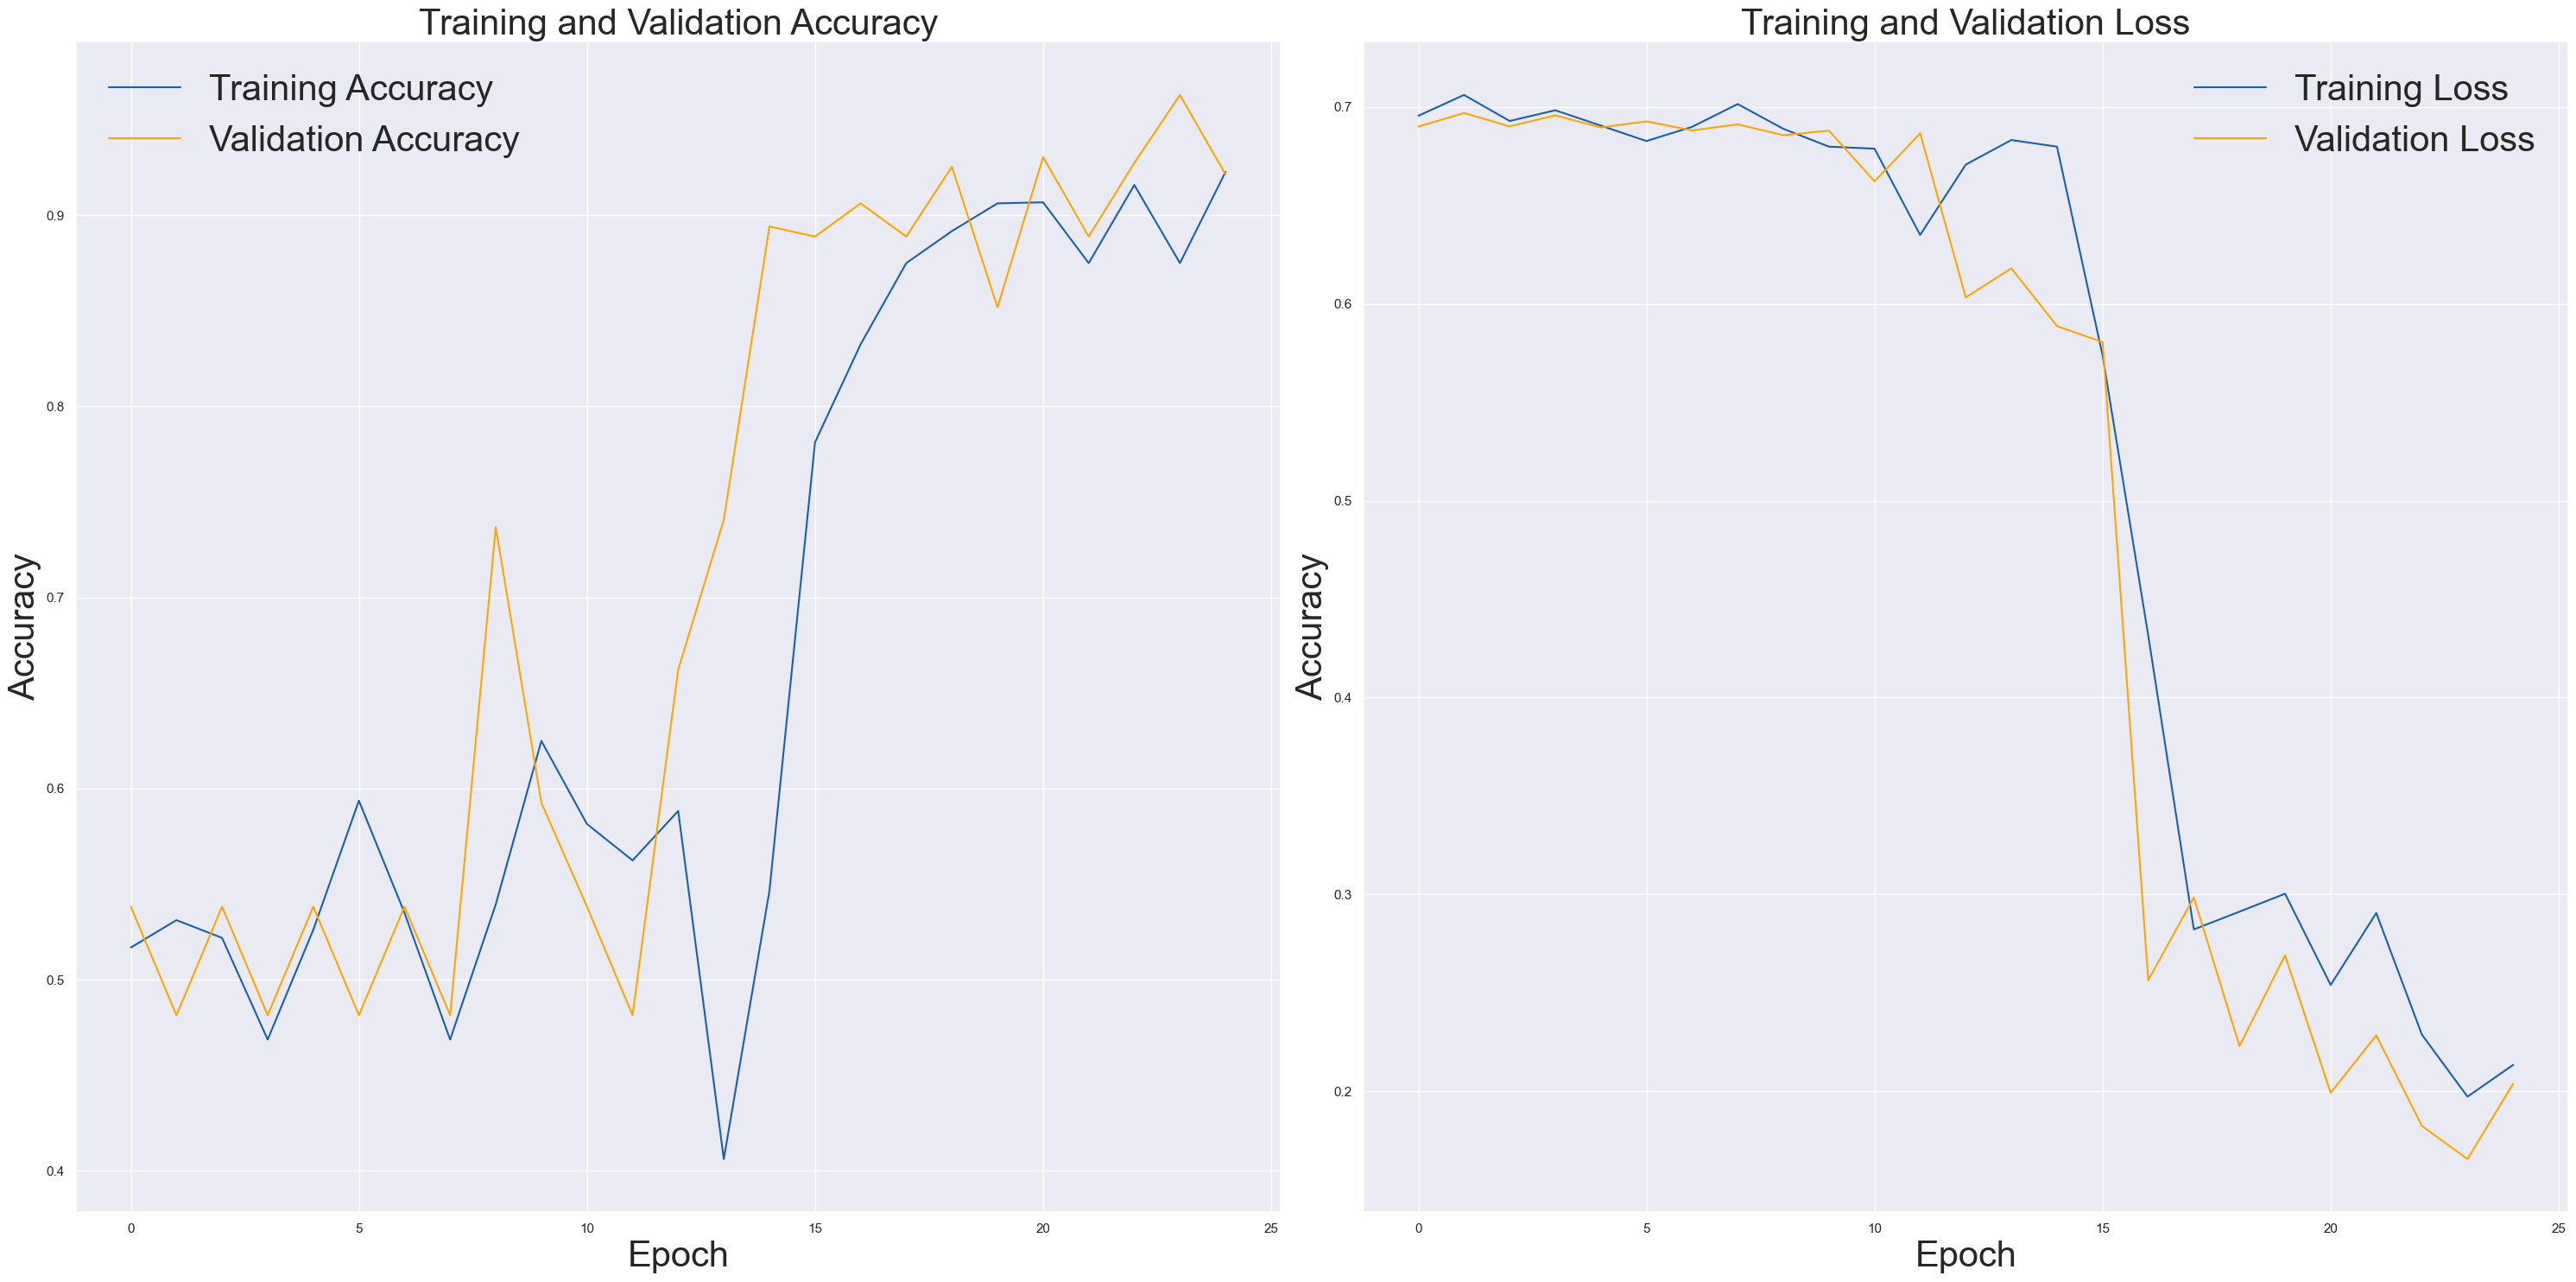

In [26]:
train_acc_imp = imp_history.history['accuracy']
val_acc_imp = imp_history.history['val_accuracy']
train_loss_imp = imp_history.history['loss']
val_loss_imp = imp_history.history['val_loss']


plot_accuracy_loss(train_acc_imp, val_acc_imp, train_loss_imp, val_loss_imp)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


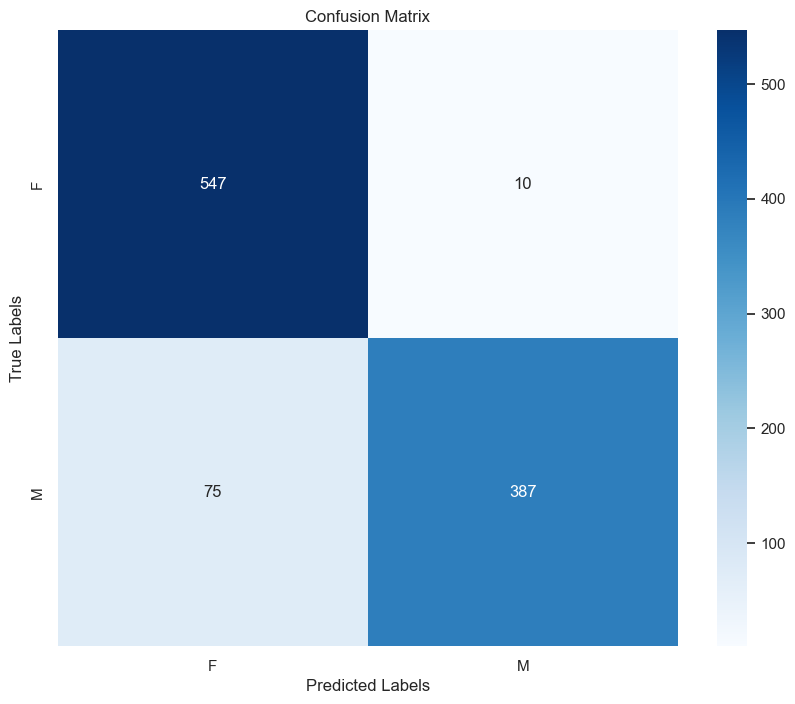

              precision    recall  f1-score   support

           F       0.88      0.98      0.93       557
           M       0.97      0.84      0.90       462

    accuracy                           0.92      1019
   macro avg       0.93      0.91      0.91      1019
weighted avg       0.92      0.92      0.92      1019



In [38]:
test_generator.reset()
predictions = imp_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan label asli dari data uji
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Laporan klasifikasi
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

_As per the graphs above, dropout has lowered the oscillations and fluctuations of the loss and accuracy val curves; yet the model's loss has risen up, therefore; **early stopping** is a must to be added to the next step of the hyperparameter tuning. The previous models had 4 conv layers, we can do opt to 3 or 2 to observe the difference._

**Keras-tuner with Hyperparameter tuning CNN Model:**

In [17]:
tensorboard_callback = TensorBoard(log_dir=log_dir+'/modelHP')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto') #Add early stopping

class MyHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        hp_model = Sequential()
        
        initializer = tf.keras.initializers.GlorotNormal() # Add initializers for the Dense layers because 
                                                            # Conv2D's default initializer is GlorotNormal.
        initializerZeros = tf.keras.initializers.Zeros() #Add zeros initializer on the softmax's weights.
        
        # 3X3X32 filters, RGB 64x64 input image.
        hp_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64,64,3), activation='relu'))
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        

        hp_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        hp_model.add(Dropout(hp.Float('drop1',
                                       min_value = 0.1,
                                       max_value = 0.5,
                                       step = 0.1))) #Add dropout
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        

        hp_model.add(Conv2D(filters= 128, kernel_size=(3, 3), activation='relu'))
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        hp_model.add(Dropout(hp.Float('drop2',
                                       min_value = 0.2,
                                       max_value = 0.6,
                                       step = 0.1))) #Add dropout


        hp_model.add(Flatten()) #Fully Connected Layer
        hp_model.add(Dense(512, kernel_initializer = initializer,  kernel_regularizer = 'l2',activation='relu'))
        hp_model.add(Dropout(0.3))
        hp_model.add(Dense(128, kernel_initializer = initializer,  kernel_regularizer = 'l2',activation='relu')) #Fully Connected Layer
        hp_model.add(Dropout(0.2))
        hp_model.add(Dense(2, kernel_initializer = initializerZeros,  kernel_regularizer = 'l2',activation='softmax'))

        hp_model.compile(loss='categorical_crossentropy',
        # Likewase in NN, CNN's do not work with Adam on this dataset, it is extremely noisy, SGD is way better than Adam.
        optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('lr', values = [0.001,0.01,0.1]),
                                                        momentum = hp.Choice('momentum', values=[0.3,0.4,0.5,0.6,0.7,0.8])), 
                                                        metrics=['accuracy'])

        return hp_model


hypermodel = MyHyperModel(num_classes=2)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=15, #15 Trials only for this Hyperparameter tuning.
    directory='my_dir',
    project_name='cnnHyperParameter')

s = tuner.search(train_generator,
             epochs=30,
             validation_data=val_generator,
             callbacks= [tensorboard_callback, early_stop],
             batch_size = 128
             )

Reloading Tuner from my_dir\cnnHyperParameter\tuner0.json


In [18]:
# Setelah pencarian hyperparameter selesai
best_model = tuner.get_best_models(num_models=1)[0]  # Ambil model terbaik

# Menampilkan summary dari model terbaik
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,518,978 (9.61 MB)

 Trainable params: 2,518,978 (9.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 282ms/step - accuracy: 0.9718 - loss: 0.1389 - val_accuracy: 0.9568 - val_loss: 0.1789
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9701 - loss: 0.1436 - val_accuracy: 0.9529 - val_loss: 0.1793
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9672 - loss: 0.1354 - val_accuracy: 0.9588 - val_loss: 0.1834
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9699 - loss: 0.1388 - val_accuracy: 0.9657 - val_loss: 0.1528
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9683 - loss: 0.1259 - val_accuracy: 0.9568 - val_loss: 0.1714
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9732 - loss: 0.1282 - val_accuracy: 0.9647 - val_loss: 0.1764
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9789 - loss: 0.1182 - val_accuracy: 0.9607 - val_loss: 0.1677


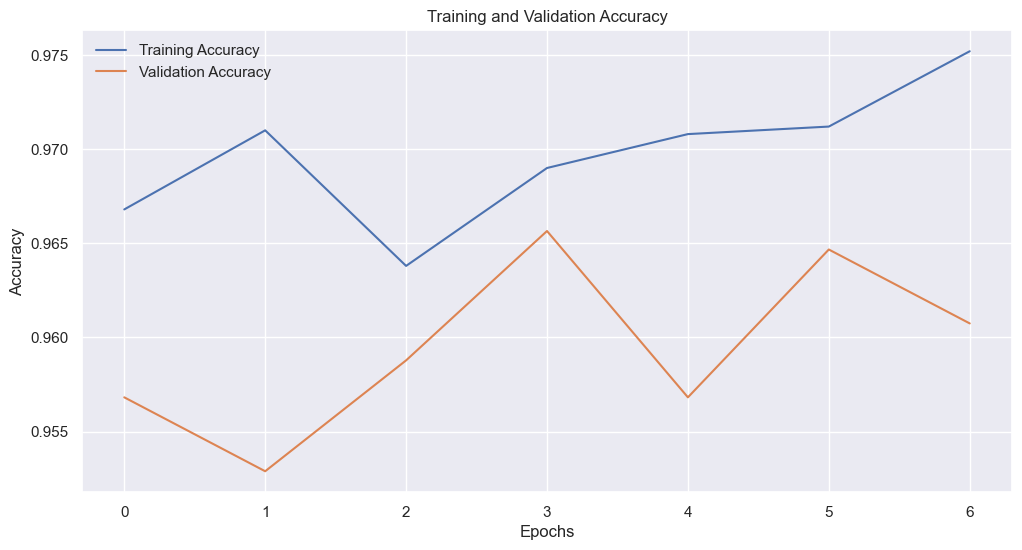

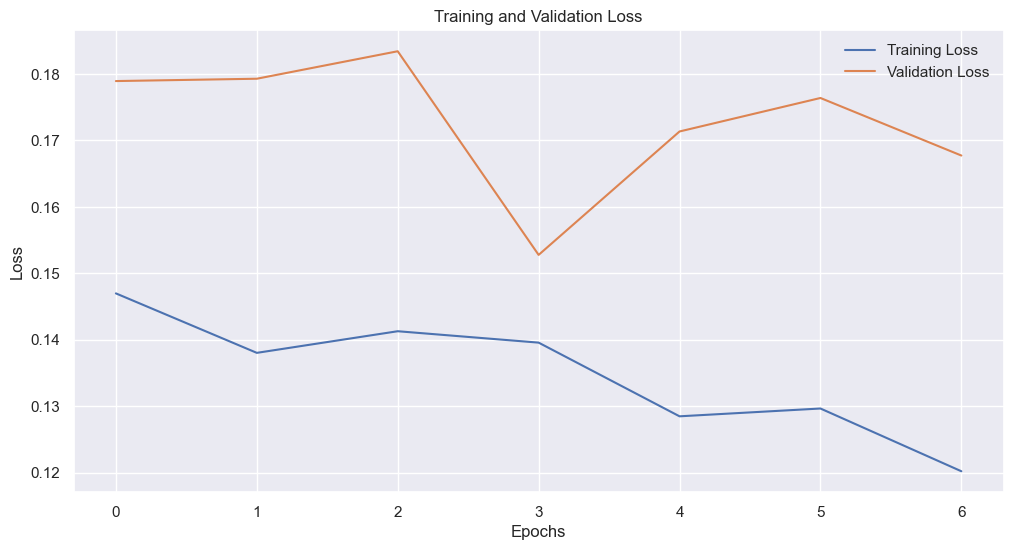

In [19]:
# Ambil model terbaik dari hasil tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Dapatkan sejarah pelatihan dari model terbaik
history = best_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[tensorboard_callback, early_stop],
    batch_size=128,
    verbose=1
)

# Plot grafik akurasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot grafik loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
class MyHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        hp_model = Sequential()
        
        initializer = tf.keras.initializers.GlorotNormal() # Add initializers for the Dense layers because 
                                                            # Conv2D's default initializer is GlorotNormal.
        initializerZeros = tf.keras.initializers.Zeros() #Add zeros initializer on the softmax's weights.
        
        # 3X3X32 filters, RGB 64x64 input image.
        hp_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64,64,3), activation='relu'))
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        

        hp_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        hp_model.add(Dropout(hp.Float('drop1',
                                       min_value = 0.1,
                                       max_value = 0.5,
                                       step = 0.1))) #Add dropout
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        

        hp_model.add(Conv2D(filters= 128, kernel_size=(3, 3), activation='relu'))
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        hp_model.add(Dropout(hp.Float('drop2',
                                       min_value = 0.2,
                                       max_value = 0.6,
                                       step = 0.1))) #Add dropout


        hp_model.add(Flatten()) #Fully Connected Layer
        hp_model.add(Dense(512, kernel_initializer = initializer,  kernel_regularizer = 'l2',activation='relu'))
        hp_model.add(Dropout(0.3))
        hp_model.add(Dense(128, kernel_initializer = initializer,  kernel_regularizer = 'l2',activation='relu')) #Fully Connected Layer
        hp_model.add(Dropout(0.2))
        hp_model.add(Dense(2, kernel_initializer = initializerZeros,  kernel_regularizer = 'l2',activation='softmax'))

        hp_model.compile(loss='categorical_crossentropy',
        # Likewase in NN, CNN's do not work with Adam on this dataset, it is extremely noisy, SGD is way better than Adam.
        optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('lr', values = [0.001,0.01,0.1]),
                                                        momentum = hp.Choice('momentum', values=[0.3,0.4,0.5,0.6,0.7,0.8])), 
                                                        metrics=['accuracy'])

        return hp_model


hypermodel = MyHyperModel(num_classes=2)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=15, #15 Trials only for this Hyperparameter tuning.
    directory='my_dir',
    project_name='cnnHyperParameter')

tuner.reload()

Reloading Tuner from my_dir\cnnHyperParameter\tuner0.json


In [30]:
tuner.results_summary()

Results summary
Results in my_dir\cnnHyperParameter
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
drop1: 0.30000000000000004
drop2: 0.2
lr: 0.01
momentum: 0.8
Score: 0.9685966372489929

Trial 06 summary
Hyperparameters:
drop1: 0.2
drop2: 0.4
lr: 0.01
momentum: 0.7
Score: 0.965652585029602

Trial 01 summary
Hyperparameters:
drop1: 0.5
drop2: 0.4
lr: 0.01
momentum: 0.5
Score: 0.9636898636817932

Trial 03 summary
Hyperparameters:
drop1: 0.1
drop2: 0.30000000000000004
lr: 0.1
momentum: 0.3
Score: 0.9597644805908203

Trial 08 summary
Hyperparameters:
drop1: 0.2
drop2: 0.5
lr: 0.1
momentum: 0.5
Score: 0.9558390378952026

Trial 13 summary
Hyperparameters:
drop1: 0.30000000000000004
drop2: 0.5
lr: 0.01
momentum: 0.5
Score: 0.9519136548042297

Trial 11 summary
Hyperparameters:
drop1: 0.1
drop2: 0.4
lr: 0.01
momentum: 0.8
Score: 0.9489696025848389

Trial 00 summary
Hyperparameters:
drop1: 0.1
drop2: 0.4
lr: 0.1
momentum: 0.5
Score: 0.93

In [31]:
tune_model = tuner.get_best_models(1)[0]

In [32]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Best hyper-parameters are:' ,best_hyperparameters.values)

Best hyper-parameters are: {'drop1': 0.30000000000000004, 'drop2': 0.2, 'lr': 0.01, 'momentum': 0.8}


In [33]:
loss, acc = tune_model.evaluate(test_generator, steps=len(test_generator))


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9535 - loss: 0.1893


In [34]:
print("Loss:", loss, "Accuracy:", acc)

Loss: 0.1878167688846588 Accuracy: 0.9558390378952026


In [35]:
loss, acc = tune_model.evaluate(train_generator, steps=len(train_generator))
print("Loss:", loss, "Accuracy:", acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9796 - loss: 0.1366
Loss: 0.14672459661960602 Accuracy: 0.9724000096321106


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


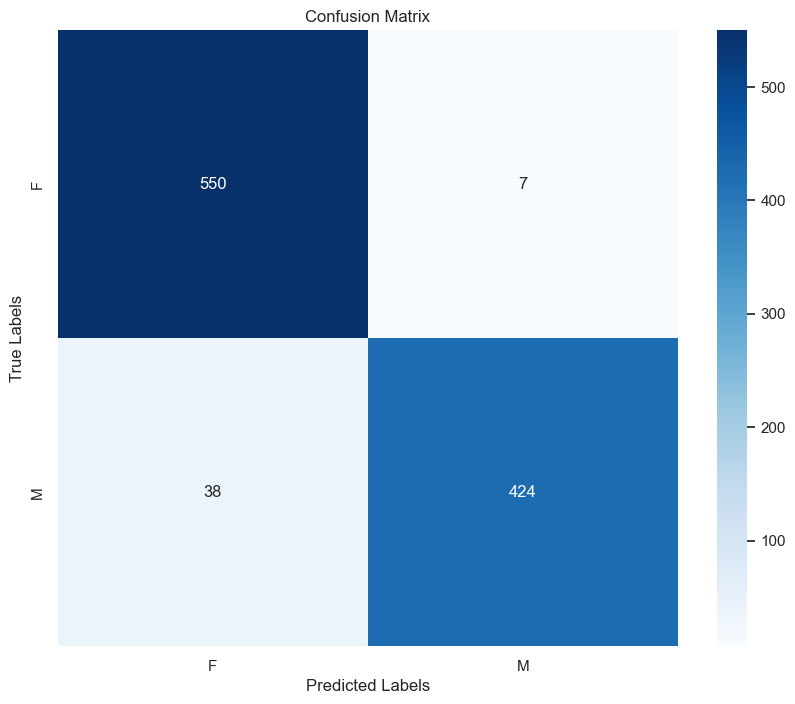

              precision    recall  f1-score   support

           F       0.94      0.99      0.96       557
           M       0.98      0.92      0.95       462

    accuracy                           0.96      1019
   macro avg       0.96      0.95      0.96      1019
weighted avg       0.96      0.96      0.96      1019



In [40]:
test_generator.reset()
best_model=tuner.get_best_models(num_models=1)[0]
predictions = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan label asli dari data uji
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Laporan klasifikasi
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

**That is the best accuracy so far from CNN, better than Neural Network (94.3%).
The hyperparameter tuning did do a great job; as the accuracy on the Cross Validation set is 95.4% and test-set is 94.06%.**


**Tensorboard (Optional)**

In [62]:
%tensorboard --logdir log_dir/'modelHP'

**Save the best nominated model:**

In [64]:
tune_model.save(models_path + '/latestCNN.h5')

**Load for future purposes:**

In [65]:
model = load_model(models_path + '/latestCNN.h5')

# Conclusion:
Convolutional neural networks are set to be a suitable (if not the best) choice to do your Voice Gender Detector, the variety of different parameters that can be alterd are quite large in number, and relatively expensive in terms of computational complexity. CNN is generally slower becuase the diversity of processes that belong to it is absolutely second to none.
- The baseline model has achieved a good combination of both CV accuracy and Test-set accuracy of 94.89%.
- The improved model has merely performed less than the baseline model, that is due to the addition of Dropout after the pooling process of each Conv layer.
- Hyperparameter tuning was done on Keras-tuner as it has achieved a blowing accuracy of 96.6% on Test and 97.8% on CV; This model from keras-tuner will be used as the main model to distinguish between a Male and a Female.

**Further readings:**
- https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7
- https://towardsdatascience.com/musical-genre-classification-with-convolutional-neural-networks-ff04f9601a74
- https://www.researchgate.net/publication/328824348_Speech_Recognition_Using_Convolutional_Neural_Networks
- https://publications.idiap.ch/downloads/papers/2018/Kabil_INTERSPEECH_2018.pdf